**Using K-Means clustering on cut-off improvements per track to see which tracks are similar**

- Finds cut-off per year per track per qualifying session and calculates YoY ratios to see how much the track speed has evolved
- Must group it by tracks which occured in consecutive years so that we can calculate ratios
- Must also remove outliers such as rain events and red flag sessions
- K is chosen by looking at silhouette and inertia
- We delibrately exclude 2020 data here as there is not a lot of overlap with previous year tracks

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans
from sklearn import metrics

In [2]:
## Getting a list of all event files in the right format for the read data function ##

files = os.listdir('/Users/chanelbrown/Desktop/Notebooks/All CSV Files - without fuel adjusted lap times')

all_events = []

for file in files:
    all_events.append(file[0:16])
    
all_events.remove('.DS_Store')

In [3]:
## Remove 2020 events ##
drop = []

for event in all_events:
    if event[-4:] == '2020':
        drop.append(event)
        
events = [x for x in all_events if x not in drop]  

**Year on Year cut-off improvement**

In [4]:
## Finds the intersection between three lists - tells us which tracks are in all three years ##

def intersect(a, b, c):
    
    intersection = list(set(a) & set(b) & set(c))
    
    return intersection

In [5]:
## Remove tracks that are not in all three years from our events list ##

event_2017 = []
event_2018 = []
event_2019 = []

# Append the track ID to a list for each year
for event in events:
    
    if event[-4:] == '2017':
        event_2017.append(event[5:8])
    else:
        pass
    
    if event[-4:] == '2018':
        event_2018.append(event[5:8])
    else:
        pass
    
    if event[-4:] == '2019':
        event_2019.append(event[5:8])
    else:
        pass

consecutive_tracks = intersect(event_2017, event_2018, event_2019)

consecutive_events = []

for event in events:
    
    if event[5:8] in consecutive_tracks:
        consecutive_events.append(event)

assert len(consecutive_events) == len(consecutive_tracks) * 3

**Load and Clean Data**

In [7]:
## Function reads data into a Pandas DataFrame from a CSV file ##

def read_data(filename):
    
    df = pd.read_csv('/Users/chanelbrown/Desktop/Notebooks/All CSV Files - without fuel adjusted lap times/%s.csv' % (filename))
    
    # select required features
    d = df[['Season', 'Circuit', 'Session', 'Driver Short Name', 'Team', 'Outing Number','Lap number',
                   'Sector 1', 'Sector 2', 'Sector 3', 'Full Lap (no fuel adjustment)']].copy()
    
    ''' some sectors have missing values (probably where car has been taken off, 
    convert the white space to NaN objects and drop them'''
    
    d.replace(' ', np.nan, inplace = True) 
                                              
    data = d.dropna()
    
    return data

**Produce object that contains all information based on best actual lap times per driver per track per season per session**

In [8]:
## Function finds which drivers made it into each sub-session ##

def find_drivers(data, session):
    
    session_data = data[data.loc[:,'Session'] == session]
    drivers = list(np.unique(session_data['Driver Short Name']))
    
    return drivers

In [9]:
## Function finds the fastest actual lap for each driver - run when looking for actual laptimes ## 

def fastest_actual_lap(data, driver, session):
    
    driver_sesh = data.loc[(data.loc[:, 'Driver Short Name'] == driver) & (data.Session == session), :]
    
    fastest = np.min(driver_sesh['Full Lap (no fuel adjustment)'])
    
    #print(f'The fastest theoretical lap for {team} in {session} is {fastest} seconds')
    
    season = data.loc[1, 'Season'] # finds the season of the fastest theoretical lap
    circuit = data.loc[1, 'Circuit'] # finds the circuit of the fastest theoretical lap
    
    team = driver_sesh.loc[driver_sesh.loc[:, 'Full Lap (no fuel adjustment)'] == fastest].iloc[0, 4] # finds the team of the fastest theoretical lap
    
    return season, circuit, team, driver, session, fastest

In [10]:
## Function puts the fastest Actual lap per driver into a dictionary where the qualifying session is the key ##

def create_qualifier_dict(data, sessions):
    
    qualifiers = {} # {'Q1' : df, 'Q2': df, 'Q3': df}
    
    for s in sessions:

        drivers = find_drivers(data, s)

        df = pd.DataFrame(columns = ['Season', 'Circuit', 'Team', 'Driver', 'Session', 'Fastest Actual Lap Time'])

        for d in drivers:

            season, circuit, team, driver, session, fastest = fastest_actual_lap(data, driver = d, session = s) 
            
            to_append = [season, circuit, team, driver, session, fastest] # values to append to empty dataframe
            a_series = pd.Series(to_append, index = df.columns) # convert into a series first
            df = df.append(a_series, ignore_index = True) 

        df = df.sort_values(by = ['Fastest Actual Lap Time'])

        qualifiers[s] = df # adds each set of results into a dictionary that has {qualifying round: data frame of fastest laps}
       
        
    return qualifiers, circuit

In [11]:
## Runs through all events available and works out actual laps for each qualifying session specified ##

sessions = ['Q1', 'Q2']

q = []
c = []

for event in consecutive_events:
    
    data = read_data(event)
    
    qualifiers, circuit = create_qualifier_dict(data, sessions)
    
    q.append(qualifiers)
    c.append(circuit)

assert len(q) == len(c)

circuit_fastest_laps = defaultdict(list) # returns a dictionary where the keys are circuits and the values are qualifying dictionaries for each year

for i, j in zip(c, q):
    circuit_fastest_laps[i].append(j)

print(circuit_fastest_laps.keys())

dict_keys(['Sochi', 'Monza', 'Suzuka', 'A1-Ring', 'Melbourne', 'Mexico City', 'Bahrain', 'Montreal', 'Spa', 'Baku', 'Monaco', 'Austin', 'Interlagos', 'Silverstone', 'Shanghai', 'Abu Dhabi', 'Barcelona', 'Singapore', 'Budapest'])


In [12]:
## Returns dictionary containing the laps for Q1 and Q2 when track and year specified ##

def return_dict(year, track, res):
    
    if res[track][0]['Q1'].loc[0, 'Season'] == year:
        return {'Q1': res[track][0]['Q1'], 'Q2': res[track][0]['Q2']}
    
    else:
        pass
    
    if res[track][1]['Q1'].loc[0, 'Season'] == year:
        return {'Q1': res[track][1]['Q1'], 'Q2': res[track][1]['Q2']}
    
    else:
        pass
    
    if res[track][2]['Q1'].loc[0, 'Season'] == year:
        return {'Q1': res[track][2]['Q1'], 'Q2': res[track][2]['Q2']}
    
    else:
        print('Enter valid arguments: year is not a string, track is a string')
     

In [13]:
## Finds cut-off points ##

def find_cutoff(input_data):

    Q1 = input_data['Q1']
    Q2 = input_data['Q2']
    
    Q1_cut = Q1.iloc[:, -1].nsmallest(16).iloc[-1] # 16th place is the score to beat, base it on below the 8th
    Q2_cut = Q2.iloc[:, -1].nsmallest(11).iloc[-1] # 11th place is the score to beat, base it on below the 5th
  
    #print(f'Q1 cut-off is {round(Q1_cut, 3)} seconds')
    #print(f'Q2 cut-off is {round(Q2_cut, 3)} seconds')
    
    return Q1_cut, Q2_cut

In [14]:
## Find the Q1 and Q2 cut-off points and the speed ratios for all years for all tracks - return info in DF ##


Q1_cutoff_ratios = pd.DataFrame(columns = ['Circuit', 'Cut-off 17-18', 'Cut-off 18-19', 'Cut-off 17-19'])
Q2_cutoff_ratios = pd.DataFrame(columns = ['Circuit', 'Cut-off 17-18', 'Cut-off 18-19', 'Cut-off 17-19'])


for track in circuit_fastest_laps.keys():
    
    event_2017 = return_dict(2017, track, circuit_fastest_laps)
    Q1_cut_2017, Q2_cut_2017 = find_cutoff(event_2017)
    
    event_2018 = return_dict(2018, track, circuit_fastest_laps)
    Q1_cut_2018, Q2_cut_2018 = find_cutoff(event_2018)
    
    event_2019 = return_dict(2019, track, circuit_fastest_laps)
    Q1_cut_2019, Q2_cut_2019 = find_cutoff(event_2019)
    
    Q1_ratio_17_18 = round(Q1_cut_2018/ Q1_cut_2017, 3)
    Q1_ratio_18_19 = round(Q1_cut_2019/ Q1_cut_2018, 3)
    Q1_ratio_17_19 = round(Q1_cut_2019/ Q1_cut_2017, 3)
    
    #print(f'Q1 track - {track}, 17:18 - {Q1_ratio_17_18}, 18:19 - {Q1_ratio_18_19}, 17:19 - {Q1_ratio_17_19}')  
    
    to_append = [track, Q1_ratio_17_18, Q1_ratio_18_19, Q1_ratio_17_19] # values to append to empty dataframe
    series = pd.Series(to_append, index = Q1_cutoff_ratios.columns) # convert into a series first
    Q1_cutoff_ratios = Q1_cutoff_ratios.append(series, ignore_index = True) 
    
    Q2_ratio_17_18 = round(Q2_cut_2018/ Q2_cut_2017, 3)
    Q2_ratio_18_19 = round(Q2_cut_2019/ Q2_cut_2018, 3)
    Q2_ratio_17_19 = round(Q2_cut_2019/ Q2_cut_2017, 3)
    
    to_append = [track, Q2_ratio_17_18, Q2_ratio_18_19, Q2_ratio_17_19] # values to append to empty dataframe
    series = pd.Series(to_append, index = Q2_cutoff_ratios.columns) # convert into a series first
    Q2_cutoff_ratios = Q2_cutoff_ratios.append(series, ignore_index = True) 
        
    #print(f'Q2 track - {track}, 17:18 - {Q2_ratio_17_18}, 18:19 - {Q2_ratio_18_19}, 17:19 - {Q2_ratio_17_19}') 

We need to remove the following events as these will be likely outliers

**Red Flag Events**

- 2019: Bak Q1 Q2
- 2019: Spa Q1
- 2019: Mza Q1
- 2019: Soc Q1
- 2019: Suz Q1

- 2018: Bah Q1
- 2018: Sil Q1
- 2018: Hok Q2
- 2018: Suz Q1

- 2017: Sil Q1
- 2017: Mza Q1
- 2017: Suz Q1
- 2017: Int Q1

**Rain Events**

- 2017: Mza
- 2017: Sil
- 2018: Bud

In [15]:
## Identifying outliers ##

# Identify 2019 outliers (set to 0)
Q1_cutoff_ratios.loc[[0, 1, 2, 8, 9], ['Cut-off 18-19', 'Cut-off 17-19']] = 0
Q2_cutoff_ratios.loc[9, ['Cut-off 18-19', 'Cut-off 17-19']] = 0

# Identify 2018 outliers
Q1_cutoff_ratios.loc[[2, 6, 13], ['Cut-off 17-18', 'Cut-off 18-19']] = 0

# Identify 2017 outliers
Q1_cutoff_ratios.loc[[1, 2, 12, 13], ['Cut-off 17-18', 'Cut-off 17-19']] = 0

# Identify rain outliers for 2018
Q1_cutoff_ratios.loc[18, ['Cut-off 17-18', 'Cut-off 18-19']] = 0
Q2_cutoff_ratios.loc[18, ['Cut-off 17-18', 'Cut-off 18-19']] = 0

# Identify rain outliers for 2017
Q1_cutoff_ratios.loc[[1, 13], ['Cut-off 17-18', 'Cut-off 17-19']] = 0
Q2_cutoff_ratios.loc[[1, 13], ['Cut-off 17-18', 'Cut-off 17-19']] = 0

In [16]:
## Removing any outliers by excluding values set to 0 ##

Q1_cutoff_17_18 = Q1_cutoff_ratios[['Circuit', 'Cut-off 17-18']]
Q1_cutoff_17_18 = Q1_cutoff_17_18[Q1_cutoff_17_18.loc[:, 'Cut-off 17-18'] != 0]

Q1_cutoff_18_19 = Q1_cutoff_ratios[['Circuit', 'Cut-off 18-19']]
Q1_cutoff_18_19 = Q1_cutoff_18_19[Q1_cutoff_18_19.loc[:, 'Cut-off 18-19'] != 0]

Q1_cutoff_17_19 = Q1_cutoff_ratios[['Circuit', 'Cut-off 17-19']]
Q1_cutoff_17_19 = Q1_cutoff_17_19[Q1_cutoff_17_19.loc[:, 'Cut-off 17-19'] != 0]



Q2_cutoff_17_18 = Q2_cutoff_ratios[['Circuit', 'Cut-off 17-18']]
Q2_cutoff_17_18 = Q2_cutoff_17_18[Q2_cutoff_17_18.loc[:, 'Cut-off 17-18'] != 0]

Q2_cutoff_18_19 = Q2_cutoff_ratios[['Circuit', 'Cut-off 18-19']]
Q2_cutoff_18_19 = Q2_cutoff_18_19[Q2_cutoff_18_19.loc[:, 'Cut-off 18-19'] != 0]

Q2_cutoff_17_19 = Q2_cutoff_ratios[['Circuit', 'Cut-off 17-19']]
Q2_cutoff_17_19 = Q2_cutoff_17_19[Q2_cutoff_17_19.loc[:, 'Cut-off 17-19'] != 0]

In [17]:
## Specifying data for K-Means ##

# Q1 17:18
data_1 = Q1_cutoff_17_18[['Cut-off 17-18']].values

# Q1 18:19
data_2 = Q1_cutoff_18_19[['Cut-off 18-19']].values

# Q1 17:19
data_3 = Q1_cutoff_17_19[['Cut-off 17-19']].values


# Q2 17:18
data_4 = Q2_cutoff_17_18[['Cut-off 17-18']].values

# Q2 18:19
data_5 = Q2_cutoff_18_19[['Cut-off 18-19']].values

# Q2 17:19
data_6 = Q2_cutoff_17_19[['Cut-off 17-19']].values

In [18]:
## K-Means clustering function that returns the centroids, labels, inertia and silhouette scores ##

def K_Means(data, dataname, k):
    
    K_Means_cluster = KMeans(n_clusters = k, init = 'k-means++', max_iter = 200, random_state = 0)
    K_Means_cluster.fit(data)
    
    # create data frame to store centroids
    centroids  = K_Means_cluster.cluster_centers_
    
    # add cluster label for each data point
    label = K_Means_cluster.labels_
    dataname['Label'] = label
    
    # evaluation metrics for clustering - inertia and silhouette score
    inertia = K_Means_cluster.inertia_
    silhouette = metrics.silhouette_score(data, label)
    
    return inertia, label, centroids, silhouette

In [19]:
## Function helps us to select the optimal value for K by considering the silhoutte score and inertia value at ##
## each k from 2 - 10 ##

def select_K(data, dataname, datastring):
    
    inertia_values = []
    silhouette_scores = []

    fig = plt.figure(figsize = (20, 10))

    zeros = [0] * len(dataname[datastring])

    for i in range (2, 8):
        inertia, label, centroids, silhouette = K_Means(data, dataname, i) # apply k means
        inertia_values.append(inertia) # store inertia scores for each k
        silhouette_scores.append(silhouette) # store silhoutte scores for each k
        centroids = pd.DataFrame(centroids, columns = ['x']) # store the centroid location for each k in its own df


        sub = fig.add_subplot(230 + i - 1) # 2 x 3 subplots
        sub.scatter(dataname[datastring], zeros, s = 40, c = dataname['Label'], cmap = 'jet') # show clusters
        sub.scatter(centroids['x'], [0] * i, s = 90, marker = 'x', color = 'r') # add on centroids

        sub.set_xlabel(datastring)
        sub.set_title(f'Number of Centroids = {i}')
    
    
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

    # plot inertia values against number of clusters - elbow method (elbow is optimal)
    ax1.plot(np.arange(2, 8), inertia_values)
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia')

    # plot silhouette scores against number of clusters - peak is optimal
    ax2.plot(np.arange(2, 8), silhouette_scores)
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette')

In [20]:
## Function plots the result of the K-means clustering with annotations for specified data and returns the labels ##

def plot_K_Means(data, dataname, datastring, k):
    
    inertia, label, centroids, silhouette = K_Means(data, dataname, k)
    
    zeros = [0] * len(dataname[datastring])

    plt.figure(figsize = (20, 8))
    plt.scatter(dataname[datastring], zeros, s = 40, c = dataname['Label'], cmap = 'jet')
    plt.xlabel(f'Improvement ratio ({datastring})')
    plt.title(f'{k} Clusters for {datastring}')

    for x, y, i in zip((dataname[datastring]), zeros, dataname.index):

        circuit = f"{dataname.loc[dataname.index == i, 'Circuit'].iloc[0]}"

        plt.annotate(circuit, (x,y), rotation = 90, textcoords = 'offset points', xytext = (0, 15), ha = 'center').set_fontsize(14)

    display(dataname)

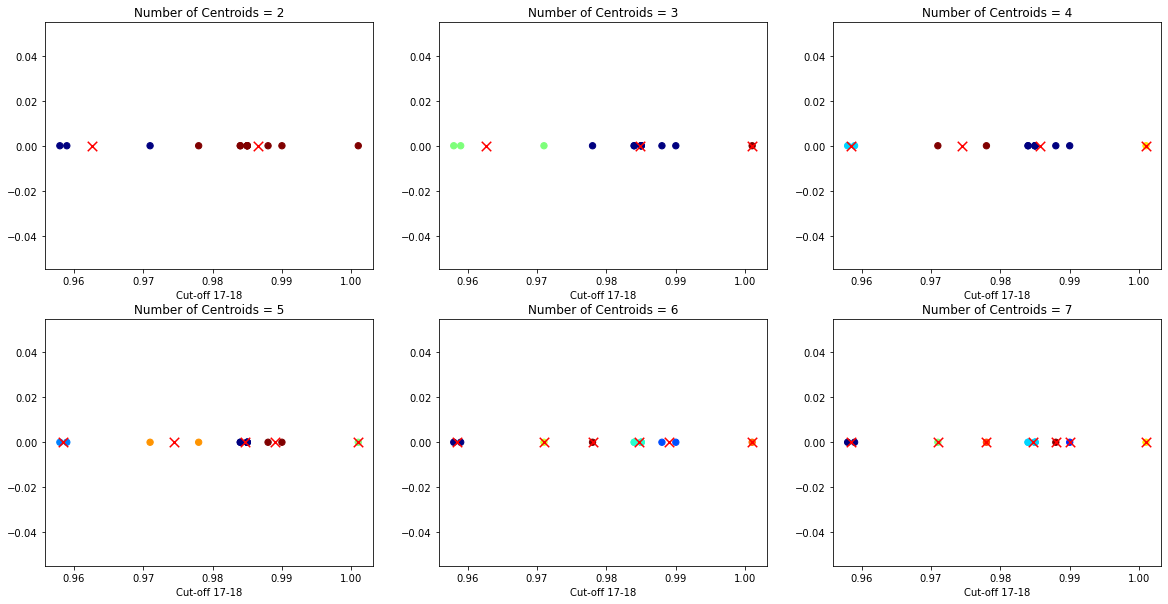

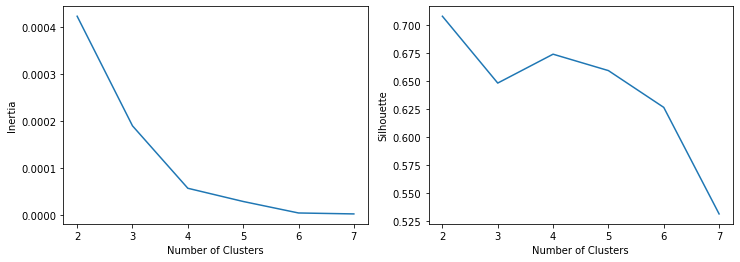

In [21]:
select_K(data_1, Q1_cutoff_17_18, 'Cut-off 17-18') # suggests 4 clusters for 17_18

,Circuit,Cut-off 17-18,Label
0,Sochi,0.985,0
3,A1-Ring,0.984,0
4,Melbourne,0.978,3
5,Mexico City,0.971,3
7,Montreal,0.985,0
8,Spa,0.985,0
9,Baku,1.001,2
10,Monaco,0.988,0
11,Austin,0.984,0
14,Shanghai,0.990,0


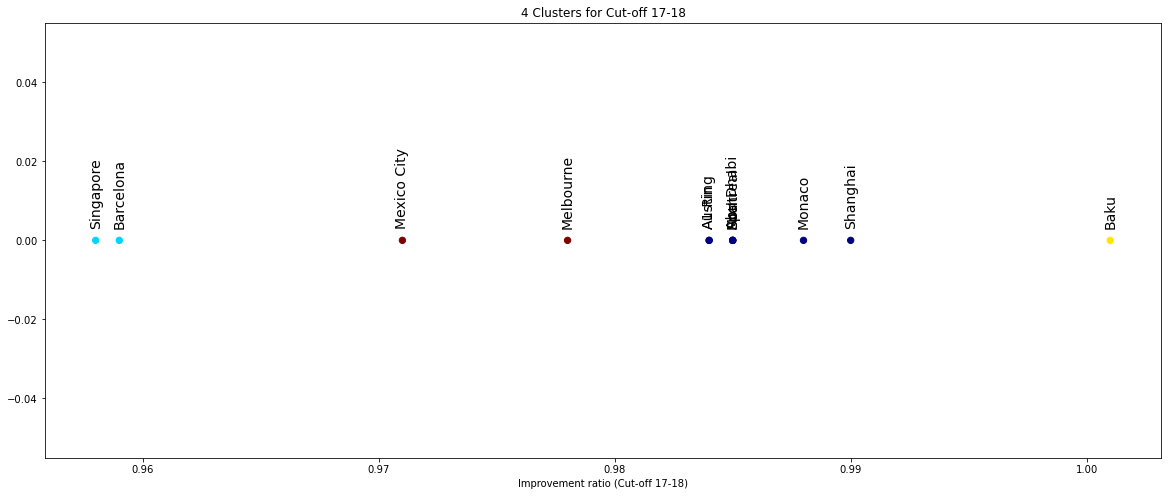

In [22]:
plot_K_Means(data_1, Q1_cutoff_17_18, 'Cut-off 17-18', 4)

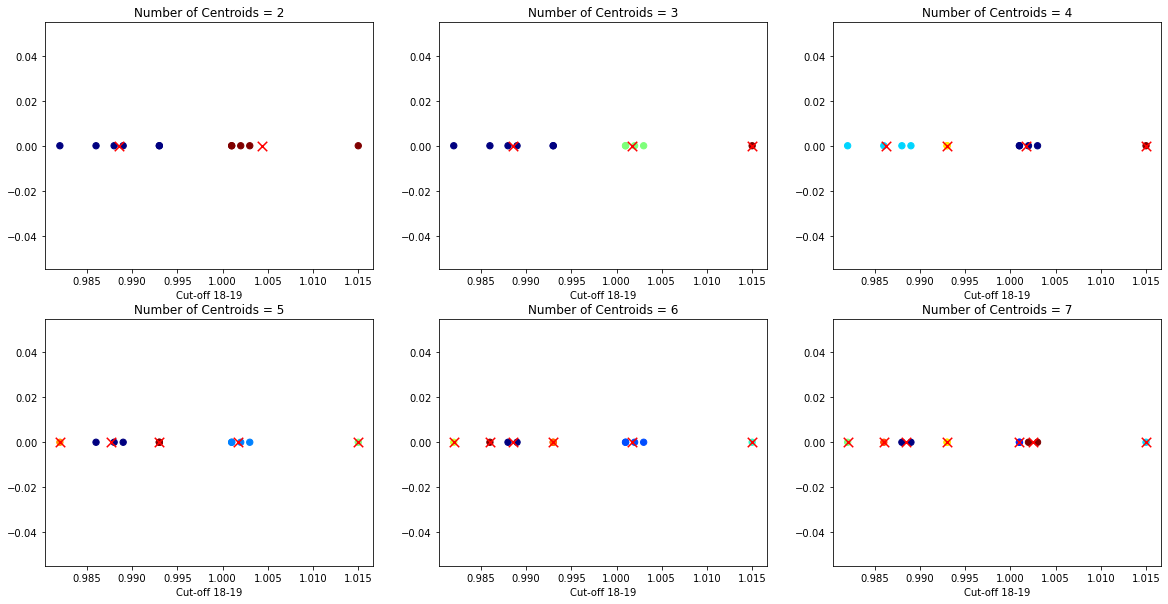

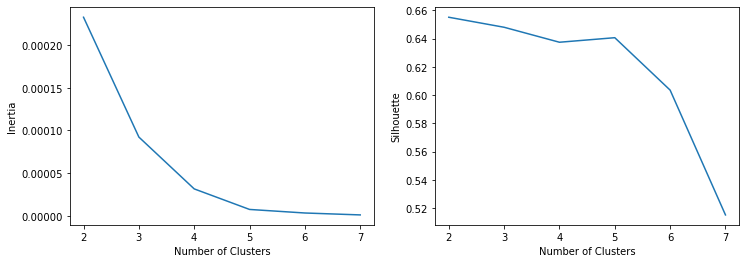

In [23]:
select_K(data_2, Q1_cutoff_18_19, 'Cut-off 18-19') # suggests 5 clusters for 18_19

,Circuit,Cut-off 18-19,Label
3,A1-Ring,0.993,4
4,Melbourne,0.982,3
5,Mexico City,1.015,2
7,Montreal,0.988,0
10,Monaco,0.986,0
11,Austin,0.989,0
12,Interlagos,1.001,1
14,Shanghai,1.002,1
15,Abu Dhabi,1.001,1
16,Barcelona,0.993,4


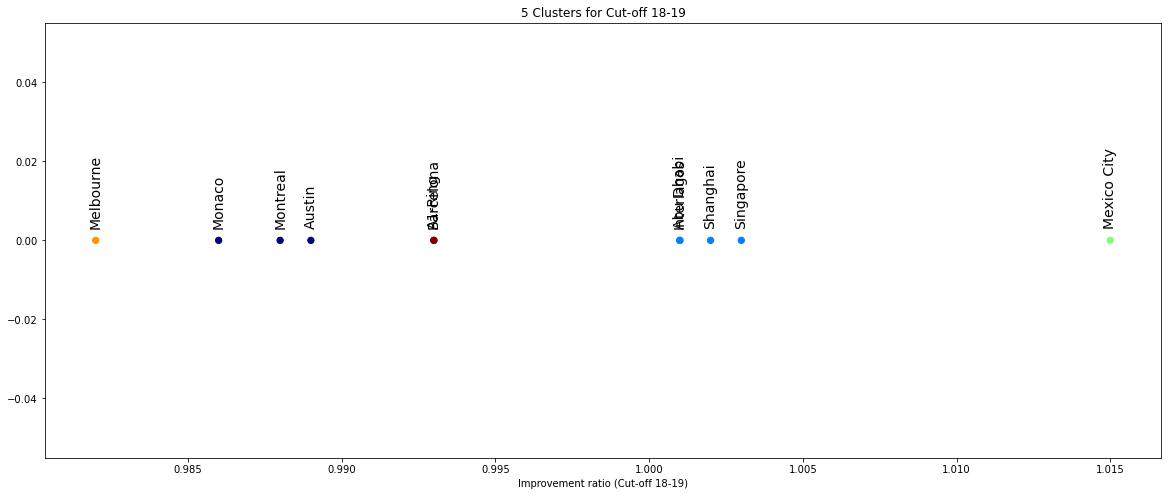

In [24]:
plot_K_Means(data_2, Q1_cutoff_18_19, 'Cut-off 18-19', 5)

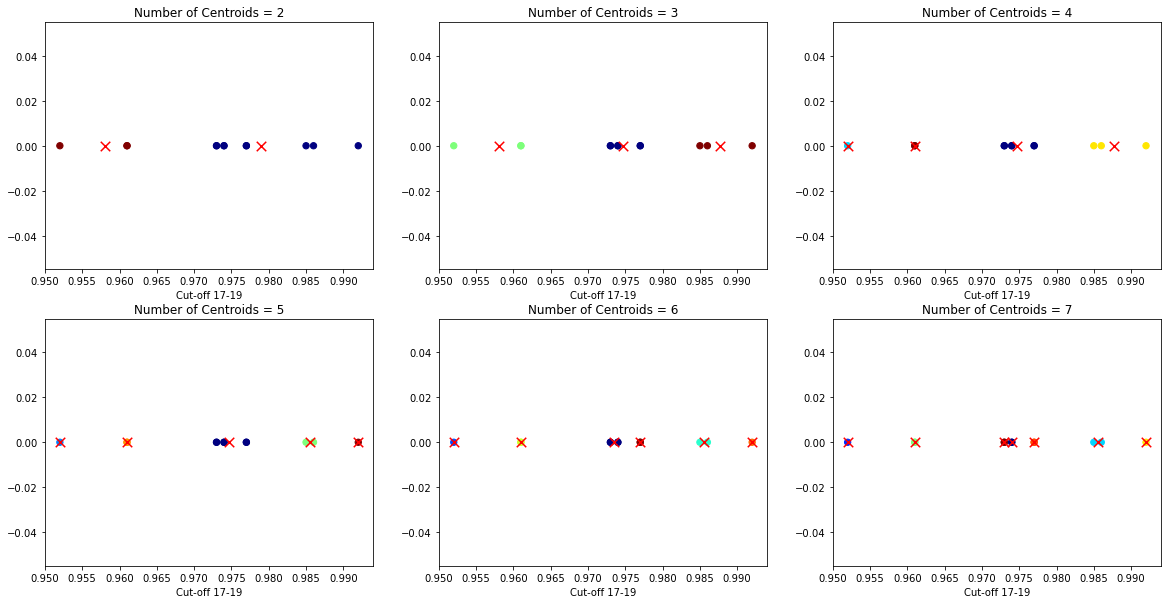

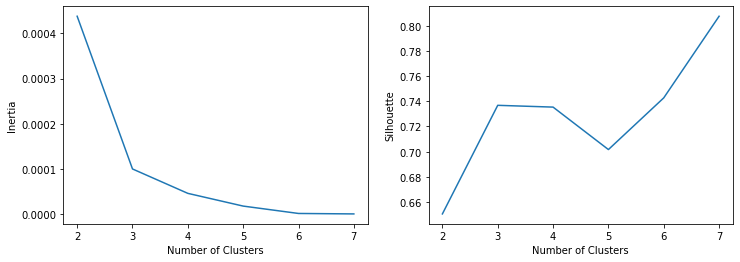

In [25]:
select_K(data_3, Q1_cutoff_17_19, 'Cut-off 17-19') # suggests 3 clusters for 17_19

,Circuit,Cut-off 17-19,Label
3,A1-Ring,0.977,0
4,Melbourne,0.961,1
5,Mexico City,0.986,2
6,Bahrain,0.977,0
7,Montreal,0.973,0
10,Monaco,0.974,0
11,Austin,0.973,0
14,Shanghai,0.992,2
15,Abu Dhabi,0.985,2
16,Barcelona,0.952,1


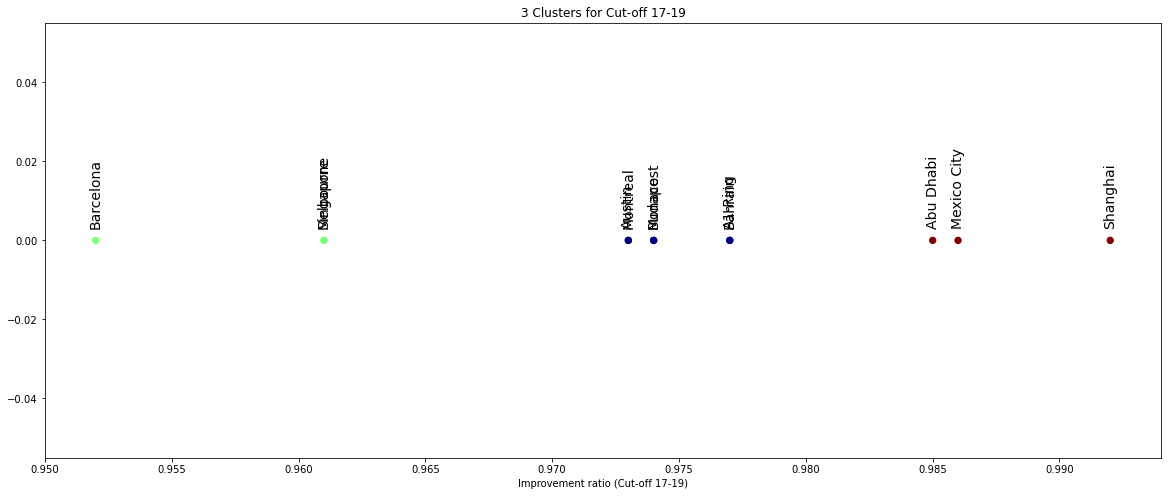

In [26]:
plot_K_Means(data_3, Q1_cutoff_17_19, 'Cut-off 17-19', 3)

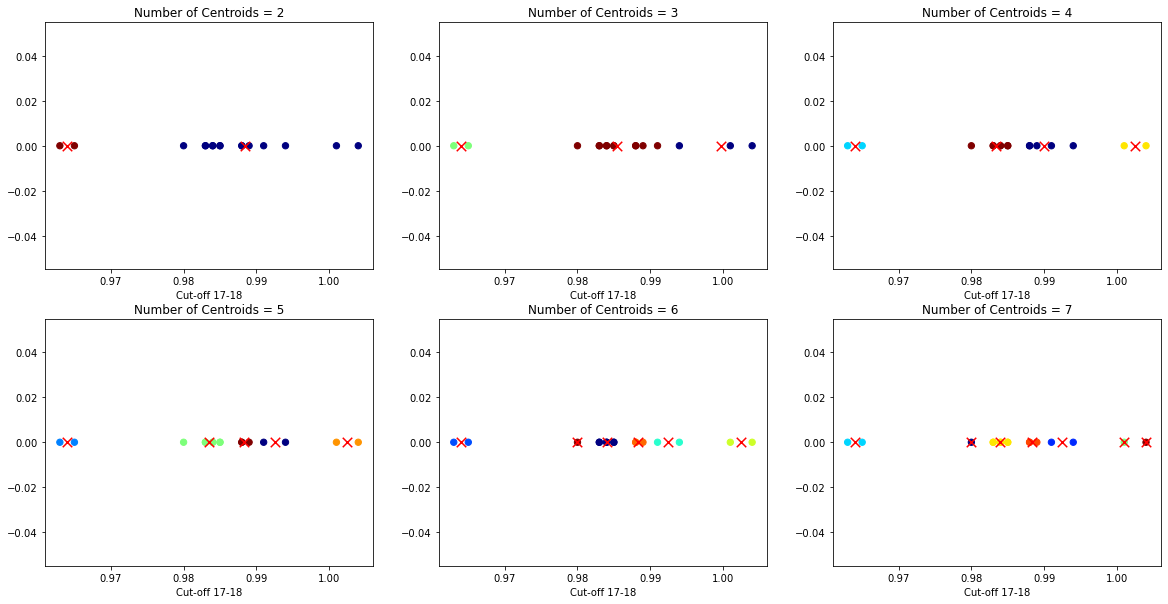

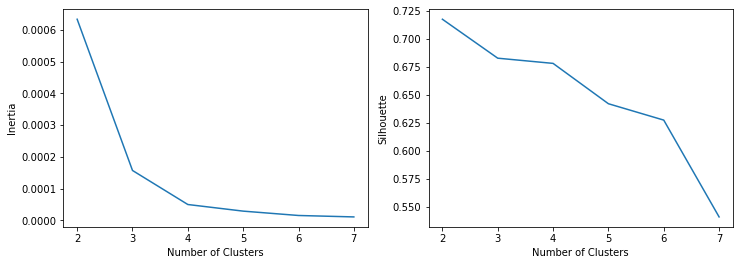

In [27]:
select_K(data_4, Q2_cutoff_17_18, 'Cut-off 17-18') # suggests 3 clusters for 17_18

,Circuit,Cut-off 17-18,Label
0,Sochi,0.980,2
2,Suzuka,1.001,0
3,A1-Ring,0.989,2
4,Melbourne,0.984,2
5,Mexico City,0.984,2
6,Bahrain,0.991,2
7,Montreal,0.985,2
8,Spa,0.988,2
9,Baku,1.004,0
10,Monaco,0.985,2


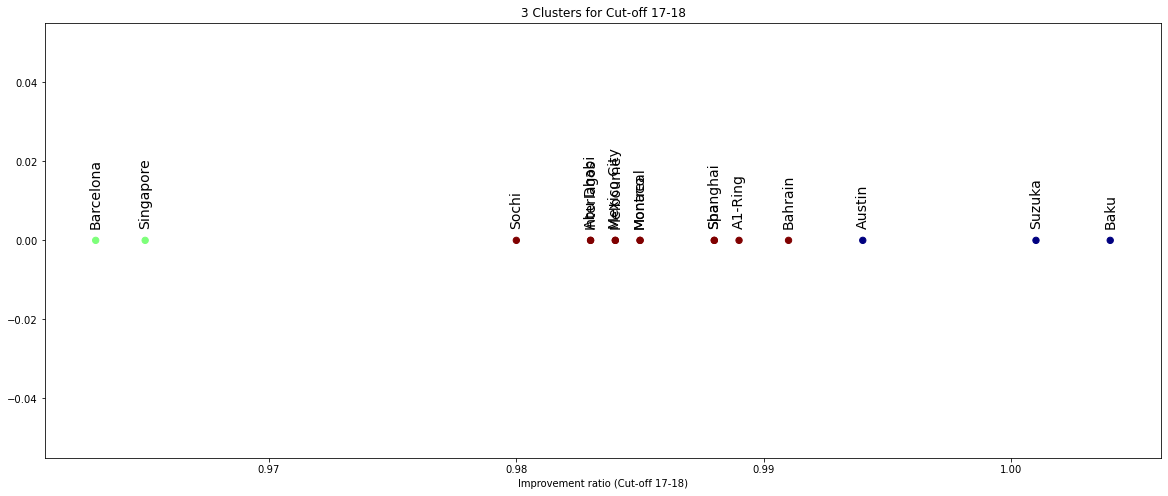

In [28]:
plot_K_Means(data_4, Q2_cutoff_17_18, 'Cut-off 17-18', 3)

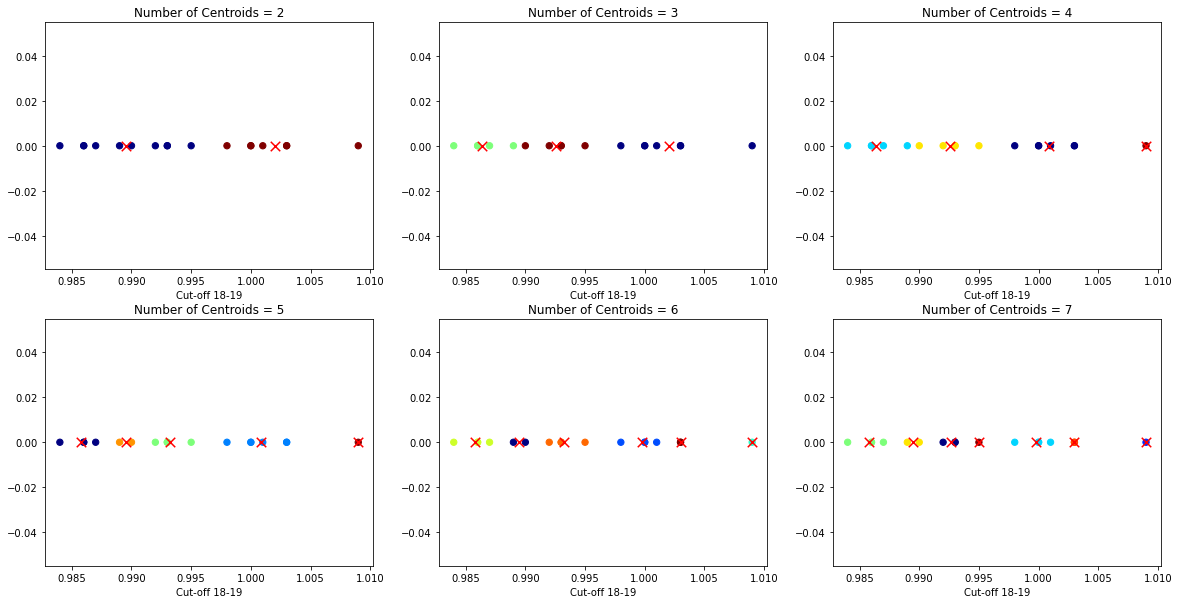

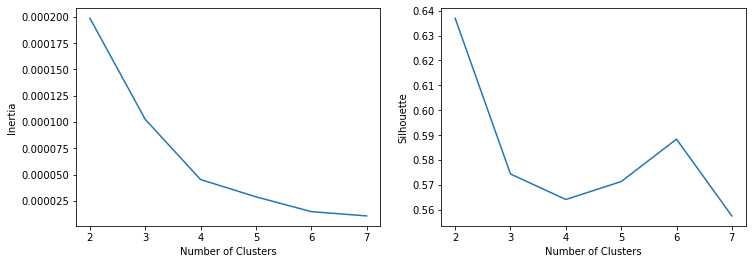

In [29]:
select_K(data_5, Q2_cutoff_18_19, 'Cut-off 18-19') # suggests 6 clusters for 17_19

,Circuit,Cut-off 18-19,Label
0,Sochi,1.000,1
1,Monza,0.986,3
2,Suzuka,0.993,4
3,A1-Ring,0.995,4
4,Melbourne,0.986,3
5,Mexico City,0.998,1
6,Bahrain,0.993,4
7,Montreal,0.989,0
8,Spa,1.009,2
10,Monaco,0.990,0


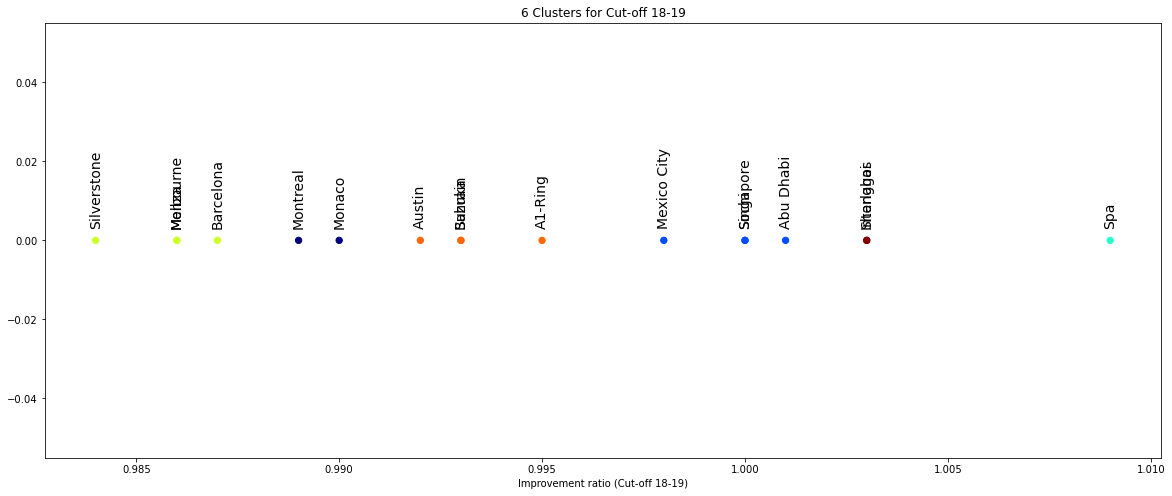

In [31]:
plot_K_Means(data_5, Q2_cutoff_18_19, 'Cut-off 18-19', 6)

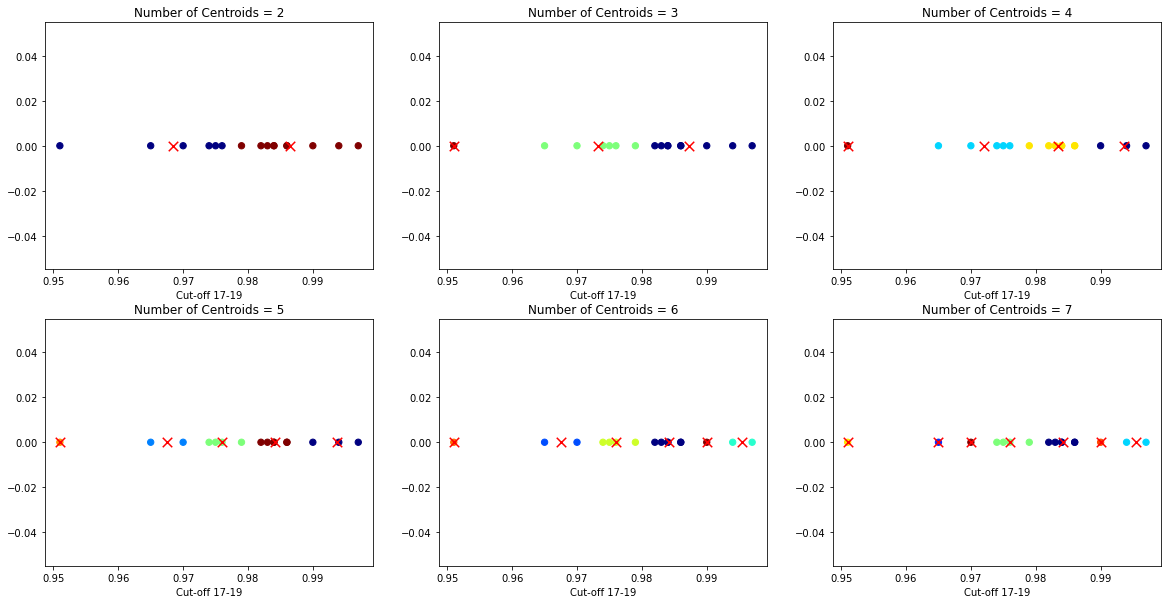

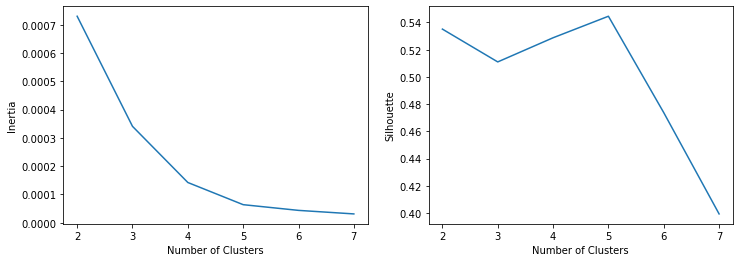

In [32]:
select_K(data_6, Q2_cutoff_17_19, 'Cut-off 17-19') # suggests 5 clusters for 17_19

,Circuit,Cut-off 17-19,Label
0,Sochi,0.979,2
2,Suzuka,0.994,0
3,A1-Ring,0.983,4
4,Melbourne,0.970,1
5,Mexico City,0.982,4
6,Bahrain,0.984,4
7,Montreal,0.974,2
8,Spa,0.997,0
10,Monaco,0.975,2
11,Austin,0.986,4


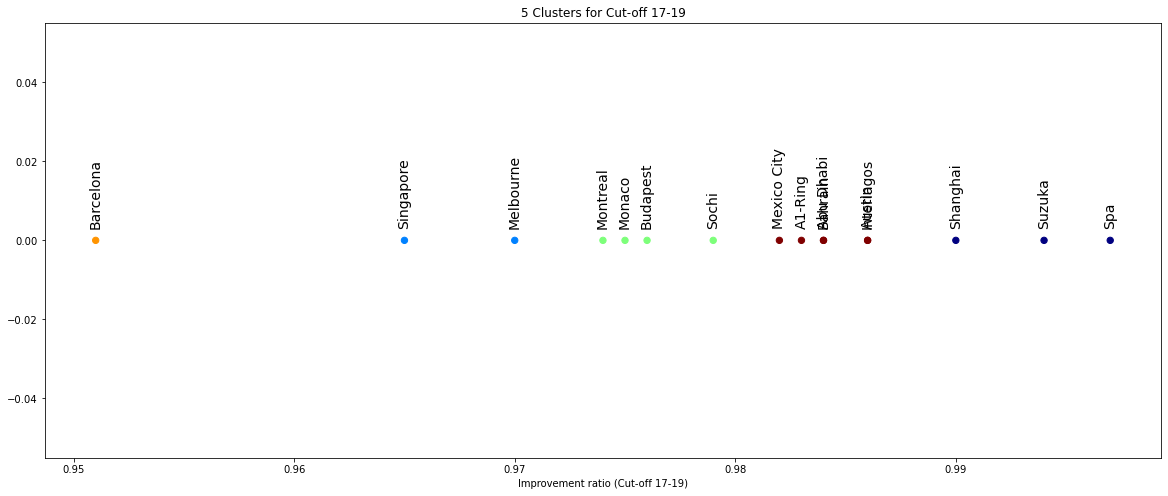

In [33]:
plot_K_Means(data_6, Q2_cutoff_17_19, 'Cut-off 17-19', 5)